# Bibliotecas

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import json

# Base de dados

In [12]:
df = pd.read_excel('Base120.xlsx')

In [13]:
def filtra_por_solucao(df, vet_solucao):
    '''Recebe um vetor solução e retorna o df filtrado para essa solução'''
    stand_prescription_map = {i + 1: vet_solucao[i] for i in range(len(vet_solucao))}
    filtered_df = df[df.apply(lambda row: row['prescrição'] == stand_prescription_map.get(row['talhao']), axis=1)]
    return filtered_df

def calcula_volume(result):
	"""
	Calculate the volume by summing specific columns of a DataFrame.
	This function takes a DataFrame `result` and returns the sum of the values
	in columns 3 to 18 (inclusive).
	Parameters:
	result (pandas.DataFrame): The input DataFrame containing the data.
	Returns:
	pandas.Series: A Series containing the sum of the specified columns.
	"""
	
    
	return result.iloc[:, 3:19].sum()

def calcula_penalidade(volume_anual):
    '''retorna penalidade por volume excedente/faltante (R$500)'''
    upper = []
    lower = []
    for v_ano in volume_anual:
        if v_ano < 140000:
            lower.append(np.abs(v_ano - 140000))
        elif v_ano > 160000:
            upper.append(np.abs(v_ano - 160000))
    return np.sum(upper + lower)*500

def calcula_vpl_aux(result, volume_ano):
    '''Calcula o VPL penalizado (função auxiliar)'''
    return np.sum(result['VPL']) - calcula_penalidade(volume_ano)

def plota_volume(df, vet_sol):
    '''Plota o gráfico do volume nos anos'''
    volume_ano = filtra_por_solucao(df, vet_sol).iloc[:, 3:19].sum()
    (volume_ano/1000).plot(kind='bar')
    plt.hlines(140, xmin=-1, xmax=16, color='red', alpha=.6)
    plt.hlines(160, xmin=-1, xmax=16, color='red', alpha=.6)
    plt.title("Volume de madeira por ano")
    plt.xlabel("Ano de Produção")
    plt.ylabel("Volume (1000 m$^3$)")

def calcula_volume_aux(df, vet_sol):
	"""
	Calculate the auxiliary volume based on the given solution vector.
	This function filters the DataFrame `df` using the solution vector `vet_sol`
	and then sums the values in columns 3 to 18 (inclusive) of the filtered DataFrame.
	Parameters:
	df (pandas.DataFrame): The input DataFrame containing the data.
	vet_sol (list or array-like): The solution vector used to filter the DataFrame.
	Returns:
	pandas.Series: A Series containing the sum of the values in columns 3 to 18 of the filtered DataFrame.
	"""
    
	return filtra_por_solucao(df, vet_sol).iloc[:, 3:19].sum()

def calcula_vpl_total(df, vet_solucao):
    '''Calcula o VPL total penalizado'''
    result = filtra_por_solucao(df, vet_solucao)
    volume_ano = calcula_volume(result)
    return calcula_vpl_aux(result, volume_ano)

def encontra_pior_ano(df, sol):
    volume_ano = calcula_volume_aux(df, sol)
    return np.argmax(np.abs(volume_ano-160000)) + 1

---

## Alteração na base de dados

In [14]:
df_2 = df.drop_duplicates(subset=['talhao'] + df.columns[3:].tolist(), keep='first')
df_2.to_csv('base_reduzida.csv', index=False)

# Busca Local

Sorteie um dos 120 talhões e gera os vizinhos para todas suas precrições, alterando a solução atual para o melhor vizinho e repetindo o processo.

## Soluções importadas


In [15]:
with open("solucoes_alpha.json", "r") as arquivo: # soluções geradas por heurística construtiva
    solucoes_alpha = json.load(arquivo)
solucoes_alpha = [np.array(sol) for sol in solucoes_alpha]

In [199]:
import random
import matplotlib.ticker as ticker

def gera_vizinhos(df, vet_solucao):
    """
    Gera vizinhos de um talhão sorteado
    """
    vizinhos = []
    talhao_sorteado = random.randint(0, 119)
    prescricoes_talhao = df[df['talhao'] == talhao_sorteado+1]['prescrição'].unique() # prescrições únicas de cada talhão
    for prescricao in prescricoes_talhao:
        vizinho = vet_solucao.copy()
        vizinho[talhao_sorteado] = prescricao # altera solução
        vizinhos.append(vizinho)
    return vizinhos

def gera_vizinhos_localizado(df, solucao):
    """
    Gera uma lista de vizinhos localizados para uma solução dada.
    Esta função identifica o pior ano em uma solução e, em seguida, encontra
    todos os talhões que podem ser colhidos naquele ano com base nas idades
    de colheita fornecidas.
    Args:
        df (pd.DataFrame): DataFrame contendo informações sobre os talhões,
                             incluindo a idade de cada talhão.
        solucao (list): Lista representando a solução atual.
        idade_colheita (dict): Dicionário onde as chaves são anos e os valores
                               são listas de idades possíveis para colheita
                               naquele ano.
    Returns:
        None: A função imprime o pior ano e os talhões possíveis para colheita
              naquele ano.
    """
    
    idade_colheita = {1: ['5', '6'],
                  2: ['4', '5', '6'],
				  3: ['3', '4', '5'],
				  4: ['2', '3', '4'],
				  5: ['1', '2', '3'],
				  6: ['1', '2', '5', '6'],
				  7: ['1', '4', '5', '6'],
				  8: ['3', '4', '5', '6'],
				  9: ['2', '3', '4', '5', '6'],
				  10: ['1', '2', '3', '4', '5'],
				  11: ['1', '2', '3', '4', '5', '6'],
				  12: ['1', '2', '3', '4', '5', '6'],
				  13: ['1', '2', '3', '4', '5', '6'],
				  14: ['1', '2', '3', '4', '5', '6'],
				  15: ['1', '2', '3', '4', '5', '6'],
				  16: ['1', '2', '3', '4', '5', '6']}
    pior_ano = encontra_pior_ano(df, solucao)
    possiveis_idades = idade_colheita[pior_ano]
    possiveis_talhoes = df[np.isin(df.loc[:, 'idade'], list(map(int, possiveis_idades)))]['talhao'].unique() # talhoes que podem fazer colheita naquele ano
    talhao_sorteado = random.sample(list(possiveis_talhoes), 1)
    vizinhos = []
    prescricoes_talhao = df[df['talhao'] == talhao_sorteado[0]]['prescrição'].unique() # prescrições únicas de cada talhão
    
    for prescricao in prescricoes_talhao:
        vizinho = solucao.copy()
        vizinho[talhao_sorteado[0]-1] = prescricao # altera solução
        vizinhos.append(vizinho)
    return vizinhos

def gera_vizinhos_sistematico(df, sol):
    """
    Gera vizinhos sistemáticos para uma solução dada.
    Parâmetros:
    df (pandas.DataFrame): DataFrame contendo os dados com colunas 'talhao' e 'prescrição'.
    sol (numpy.ndarray): Array representando a solução atual.
    Retorna:
    numpy.ndarray: Array de vizinhos gerados sistematicamente.
    """
    
    # Gera 120 vizinhos com talhões alterados sistematicamente para um prescrição aleatória
    vizinhos = np.tile(sol, (120, 1))
    for pos, vizinho in enumerate(vizinhos):
        prescricoes = df[df['talhao'] == pos + 1]['prescrição'].unique()
        vizinho[pos] = random.choice(prescricoes)
        
    return vizinhos

def varre_vizinhos(vizinhos, sol_atual, df, metodo, max_calculos_obj):
    """
    Returns the neighbor with the highest VPL.
    """
    max_vpl = calcula_vpl_total(df, sol_atual)  # Initialize with negative infinity to ensure the first neighbor is considered
    melhor_vizinho = sol_atual
    count_calculos_obj = 0

    for vizinho in vizinhos:
        if count_calculos_obj >= max_calculos_obj: # não entra na primeira iteração
            break
        
        vpl_atual = calcula_vpl_total(df, vizinho)
        count_calculos_obj += 1
        
        if metodo=='mm': # melhor melhor
            if vpl_atual > max_vpl:
                max_vpl = vpl_atual
                melhor_vizinho = vizinho
        elif metodo=='pm': # primeiro melhor
            if vpl_atual > max_vpl:
                max_vpl = vpl_atual
                melhor_vizinho = vizinho
                break

    return melhor_vizinho, count_calculos_obj  # Return the neighbor with the highest VPL

def busca_local(df, sol_atual, tempo_max=np.inf, max_calculos_obj=np.inf, seed=42, metodo='mm', vizinhanca='aleatoria'):
    inicio = time.time()
    counter_melhor_vizinho, counter_nova_solucao, counter_quant_sol, counter_calculos_obj = 0, 0, 0, 0
    melhores_vpl = []
    random.seed(seed)

    while True:
        if time.time() - inicio > tempo_max or (tempo_max == np.inf and counter_calculos_obj >= max_calculos_obj): # critérios de parada
            print("Tempo máximo atingido")
            break
        
        # gera diferentes vizinhanças 
        if vizinhanca=='aleatoria':
            vizinhos_sol_atual = gera_vizinhos(df, sol_atual)
        elif vizinhanca=='localizada':
            vizinhos_sol_atual = gera_vizinhos_localizado(df, sol_atual)
        elif vizinhanca=='sistematica':
            vizinhos_sol_atual = gera_vizinhos_sistematico(df, sol_atual)
            
        counter_calculos_obj_aux = 0
        melhor_vizinho, counter_calculos_obj_aux = varre_vizinhos(vizinhos_sol_atual, sol_atual, df, metodo=metodo, max_calculos_obj=max_calculos_obj)
        counter_calculos_obj += counter_calculos_obj_aux

        if all(melhor_vizinho == sol_atual): # nunhum vizinho melhor
            counter_nova_solucao +=1
        else:
            sol_atual = melhor_vizinho
            melhores_vpl.append(calcula_vpl_total(df, sol_atual))
            counter_melhor_vizinho += 1
            counter_quant_sol += 1
    
    # plt.plot(np.linspace(0, tempo_max, counter_quant_sol), melhores_vpl, label=metodo) # plot por tempo
    # plt.plot(range(counter_quant_sol), melhores_vpl, label=metodo) # plot por iterações de melhora
    # plt.xlabel('Número de iterações')
    # plt.ylabel('VPL')
    # plt.title('VPL ao longo das iterações')
    # plt.grid(True)
    # plt.legend()
    # plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
    # plt.ticklabel_format(style='plain', axis='x') 

    print(counter_melhor_vizinho, ' trocas para melhor vizinho')
    print(counter_nova_solucao, ' trocas para nova solução')
    return (calcula_vpl_total(df, sol_atual), sol_atual)

In [17]:
calcula_vpl_total(df_2, solucoes_alpha[2])

np.int64(-54932408)

---

## Gerar vizinhança 1


In [314]:
def plot_calculos_obj(dicionario, vizinhanca):
    """
    Plota gráficos de VPL (Valor Presente Líquido) em função do número máximo de cálculos de função objetivo em relação aos métodos MM e PM.
    Parâmetros:
    dicionario (dict): Um dicionário onde as chaves são o número máximo de cálculos de função objetivo e os valores são 
                       dicionários internos com chaves 'mm' e 'pm' representando diferentes métodos de cálculo de VPL.
    O gráfico gerado terá:
    - Eixo X: Número de cálculos da função objetivo.
    - Eixo Y: VPL (Valor Presente Líquido).
    - Duas linhas: Uma para 'MM' e outra para 'PM'.
    """
    
    x = dicionario.keys()
    y_mm = []
    y_pm = []
    for max_calc, inner_dict in dicionario.items():
        for k, v in inner_dict.items():
            if k == 'mm':
                y_mm.append(v)
            if k == 'pm':
                y_pm.append(v)
    
    plt.plot(x, y_mm, '-o', label='MM')
    plt.plot(x, y_pm, '-o', label='PM')
        
    plt.xlabel('Número cálculos função da objetivo')
    plt.ylabel('VPL')
    plt.title(f'VPL por número máximo de cálculos de função objetivo e vizinhança {vizinhanca.capitalize()}')
    plt.grid(True)
    plt.legend()
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
    plt.ticklabel_format(style='plain', axis='x') 

In [315]:
num_calculos_obj = [500, 1000, 5000, 10000, 50000]

In [316]:
v1_num_calc_vpl = {num: {'mm': 0, 'pm': 0} for num in num_calculos_obj}

for max_calculos_obj in v1_num_calc_vpl.items():
    calculos_dict = max_calculos_obj[1]
    
    vpl_busca_local, sol_busca_local = busca_local(df_2,
                                                   solucoes_alpha[2],
                                                   seed=11,
                                                   max_calculos_obj=max_calculos_obj[0],
                                                    # tempo_max=10,
                                                   metodo='mm',
                                                   vizinhanca='aleatoria')
    print('Melhor melhor\nVPL: ', vpl_busca_local)
    calculos_dict['mm'] = vpl_busca_local

    vpl_busca_local, sol_busca_local = busca_local(df_2, 
                                                    solucoes_alpha[2], 
                                                    seed=11,
                                                    max_calculos_obj=max_calculos_obj[0],
                                                    # tempo_max=109,
                                                    metodo='pm',
                                                    vizinhanca='aleatoria')
    calculos_dict['pm'] = vpl_busca_local
    print('Primeiro melhor\nVPL: ', vpl_busca_local)
    

Tempo máximo atingido
17  trocas para melhor vizinho
6  trocas para nova solução
Melhor melhor
VPL:  21348495
Tempo máximo atingido
43  trocas para melhor vizinho
15  trocas para nova solução
Primeiro melhor
VPL:  18021214
Tempo máximo atingido
25  trocas para melhor vizinho
20  trocas para nova solução
Melhor melhor
VPL:  29811598.0
Tempo máximo atingido
58  trocas para melhor vizinho
31  trocas para nova solução
Primeiro melhor
VPL:  21627868
Tempo máximo atingido
67  trocas para melhor vizinho
168  trocas para nova solução
Melhor melhor
VPL:  30089946.0
Tempo máximo atingido
115  trocas para melhor vizinho
195  trocas para nova solução
Primeiro melhor
VPL:  29814693.0
Tempo máximo atingido
87  trocas para melhor vizinho
380  trocas para nova solução
Melhor melhor
VPL:  30270958.0
Tempo máximo atingido
134  trocas para melhor vizinho
412  trocas para nova solução
Primeiro melhor
VPL:  29883683.0
Tempo máximo atingido
116  trocas para melhor vizinho
2159  trocas para nova solução
Melh

In [327]:
v1_num_calc_vpl

{500: {'mm': np.int64(21348495), 'pm': np.int64(18021214)},
 1000: {'mm': np.float64(29811598.0), 'pm': np.int64(21627868)},
 5000: {'mm': np.float64(30089946.0), 'pm': np.float64(29814693.0)},
 10000: {'mm': np.float64(30270958.0), 'pm': np.float64(29883683.0)},
 50000: {'mm': np.float64(30408128.0), 'pm': np.float64(30196617.0)}}

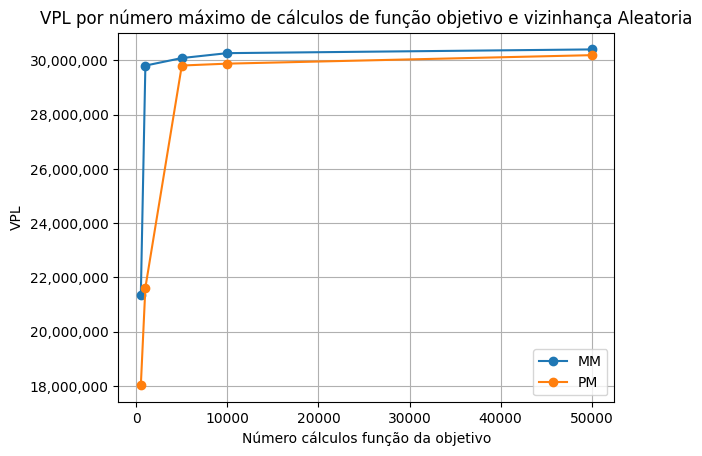

In [317]:
plot_calculos_obj(v1_num_calc_vpl, vizinhanca='aleatoria')

In [318]:
# plota_volume(df_2, sol_busca_local)

---

## Gerar vizinhança 2

3 casos:

1. Dados o ano que mais acima da produção máxima, escolher dentro os talhões que podem fazer colheita nesse ano, escolher uma prescrição do melhor vizinho

2. Dados o ano que mais abaixo da produção mínima, escolher dentro os talhões que podem fazer colheita nesse ano, uma prescrição do melhor vizinho

3. Dados o ano dentro do limite e mais próximo da produção máxima, escolher dentro os talhões que podem fazer colheita nesse ano, escolher uma prescrição do melhor vizinho

In [319]:
v2_num_calc_vpl = {num: {'mm': 0, 'pm': 0} for num in num_calculos_obj}

for max_calculos_obj in v2_num_calc_vpl.items():
    calculos_dict = max_calculos_obj[1]
    
    vpl_busca_local, sol_busca_local = busca_local(df_2,
                                                   solucoes_alpha[2],
                                                   seed=11,
                                                   max_calculos_obj=max_calculos_obj[0],
                                                    # tempo_max=10,
                                                   metodo='mm',
                                                   vizinhanca='localizada')
    print('Melhor melhor\nVPL: ', vpl_busca_local)
    calculos_dict['mm'] = vpl_busca_local

    vpl_busca_local, sol_busca_local = busca_local(df_2, 
                                                    solucoes_alpha[2], 
                                                    seed=11,
                                                    max_calculos_obj=max_calculos_obj[0],
                                                    # tempo_max=109,
                                                    metodo='pm',
                                                    vizinhanca='localizada')
    calculos_dict['pm'] = vpl_busca_local
    print('Primeiro melhor\nVPL: ', vpl_busca_local)
    

Tempo máximo atingido
14  trocas para melhor vizinho
8  trocas para nova solução
Melhor melhor
VPL:  21619441
Tempo máximo atingido
37  trocas para melhor vizinho
15  trocas para nova solução
Primeiro melhor
VPL:  20433403
Tempo máximo atingido
21  trocas para melhor vizinho
26  trocas para nova solução
Melhor melhor
VPL:  29609350
Tempo máximo atingido
53  trocas para melhor vizinho
28  trocas para nova solução
Primeiro melhor
VPL:  25007382
Tempo máximo atingido
41  trocas para melhor vizinho
194  trocas para nova solução
Melhor melhor
VPL:  29938363.0
Tempo máximo atingido
81  trocas para melhor vizinho
199  trocas para nova solução
Primeiro melhor
VPL:  29364661
Tempo máximo atingido
53  trocas para melhor vizinho
415  trocas para nova solução
Melhor melhor
VPL:  29986243.0
Tempo máximo atingido
90  trocas para melhor vizinho
424  trocas para nova solução
Primeiro melhor
VPL:  29729324.0
Tempo máximo atingido
59  trocas para melhor vizinho
2217  trocas para nova solução
Melhor melh

In [326]:
v2_num_calc_vpl

{500: {'mm': np.int64(21619441), 'pm': np.int64(20433403)},
 1000: {'mm': np.int64(29609350), 'pm': np.int64(25007382)},
 5000: {'mm': np.float64(29938363.0), 'pm': np.int64(29364661)},
 10000: {'mm': np.float64(29986243.0), 'pm': np.float64(29729324.0)},
 50000: {'mm': np.float64(30025423.0), 'pm': np.float64(30425730.0)}}

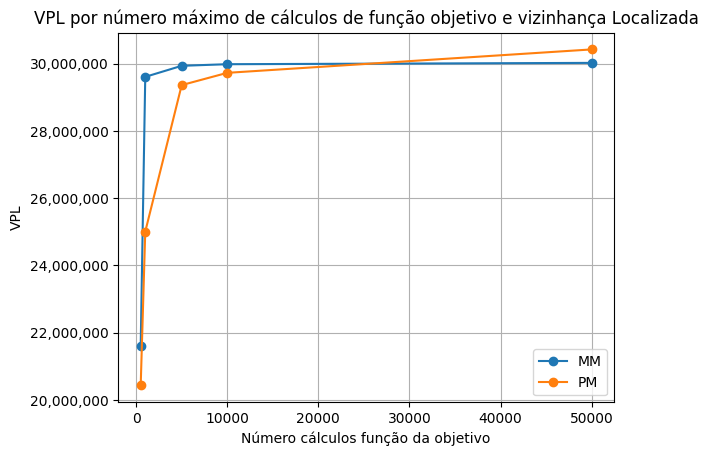

In [320]:
plot_calculos_obj(v2_num_calc_vpl, vizinhanca='localizada')

In [321]:
# plota_volume(df_2, sol_busca_local)

---

## Gera vizinhanças 3

120 vizinhos compostos de uma troca sistematica de todos talhões por uma prescrição aleatória

In [322]:
v3_num_calc_vpl = {num: {'mm': 0, 'pm': 0} for num in num_calculos_obj}

for max_calculos_obj in v3_num_calc_vpl.items():
    calculos_dict = max_calculos_obj[1]
    
    vpl_busca_local, sol_busca_local = busca_local(df_2,
                                                   solucoes_alpha[2],
                                                   seed=11,
                                                   max_calculos_obj=max_calculos_obj[0],
                                                    # tempo_max=10,
                                                   metodo='mm',
                                                   vizinhanca='sistematica')
    print('Melhor melhor\nVPL: ', vpl_busca_local)
    calculos_dict['mm'] = vpl_busca_local

    vpl_busca_local, sol_busca_local = busca_local(df_2, 
                                                    solucoes_alpha[2], 
                                                    seed=11,
                                                    max_calculos_obj=max_calculos_obj[0],
                                                    # tempo_max=10,
                                                    metodo='pm',
                                                    vizinhanca='sistematica')
    calculos_dict['pm'] = vpl_busca_local
    print('Primeiro melhor\nVPL: ', vpl_busca_local)
    

Tempo máximo atingido
5  trocas para melhor vizinho
0  trocas para nova solução
Melhor melhor
VPL:  12326221
Tempo máximo atingido
36  trocas para melhor vizinho
0  trocas para nova solução
Primeiro melhor
VPL:  2395275
Tempo máximo atingido
9  trocas para melhor vizinho
0  trocas para nova solução
Melhor melhor
VPL:  28115354
Tempo máximo atingido
57  trocas para melhor vizinho
0  trocas para nova solução
Primeiro melhor
VPL:  11299246
Tempo máximo atingido
36  trocas para melhor vizinho
6  trocas para nova solução
Melhor melhor
VPL:  29832078
Tempo máximo atingido
110  trocas para melhor vizinho
13  trocas para nova solução
Primeiro melhor
VPL:  30248091.0
Tempo máximo atingido
74  trocas para melhor vizinho
10  trocas para nova solução
Melhor melhor
VPL:  30162583
Tempo máximo atingido
139  trocas para melhor vizinho
43  trocas para nova solução
Primeiro melhor
VPL:  30400638.0
Tempo máximo atingido
138  trocas para melhor vizinho
279  trocas para nova solução
Melhor melhor
VPL:  30

In [325]:
v3_num_calc_vpl

{500: {'mm': np.int64(12326221), 'pm': np.int64(2395275)},
 1000: {'mm': np.int64(28115354), 'pm': np.int64(11299246)},
 5000: {'mm': np.int64(29832078), 'pm': np.float64(30248091.0)},
 10000: {'mm': np.int64(30162583), 'pm': np.float64(30400638.0)},
 50000: {'mm': np.float64(30556244.0), 'pm': np.float64(30680128.0)}}

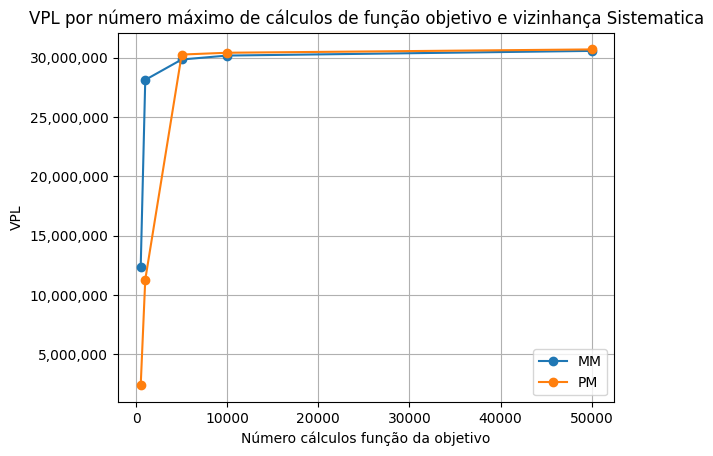

In [323]:
plot_calculos_obj(v3_num_calc_vpl, vizinhanca='sistematica')

In [303]:
# plota_volume(df_2, sol_busca_local)